##### $Name:\,\color{blue}{Christopher\,J.\,Watson}$
##### $School:\,\color{blue}{Marcos\,School\,of\,Engineering,\,University\,of\,San\,Diego}$
##### $Class:\,\color{blue}{AAI\,540-\,Machine\,Learning\,\&\,Operations}$
##### $Assignment:\,\color{blue}{MSAAI\,Data\,Collection}$
##### $Date:\,\color{blue}{1/19/2024}$

In [1]:
#import libraries
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#set file path for first level data folder
datapath=r'./archive/'
#set file path for meter 1/2 hourly kWh data folder
meterdatapath = r'./archive/halfhourly_dataset/halfhourly_dataset/'
#create list of file names for meter 1/2 hourly kWh data files
filenamelist = os.listdir(meterdatapath)
#list first level folder file names
os.listdir(datapath)

['acorn_details.csv',
 'daily_dataset',
 'daily_dataset.csv',
 'darksky_parameters_documentation.html',
 'halfhourly_dataset',
 'hhblock_dataset',
 'housekWh.csv',
 'informations_households.csv',
 'uk_bank_holidays.csv',
 'weather_daily_darksky.csv',
 'weather_hourly_darksky.csv']

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
import lightgbm as lgb

In [4]:
#load CSV file to data frame meterconsuptiondata
meterconsumptiondata = pd.read_csv(datapath+'/housekWh.csv',index_col='tstp',parse_dates=True)

In [5]:
#Take average of all meters to hourly interval
houseAVG = meterconsumptiondata.mean(axis=1).to_frame()
houseAVG.columns = ['kWh']

In [6]:
#load weather infomation
weather_hourly_darksky = pd.read_csv(os.path.join(datapath,'weather_hourly_darksky.csv'),index_col='time',parse_dates=True)

<Axes: xlabel='time'>

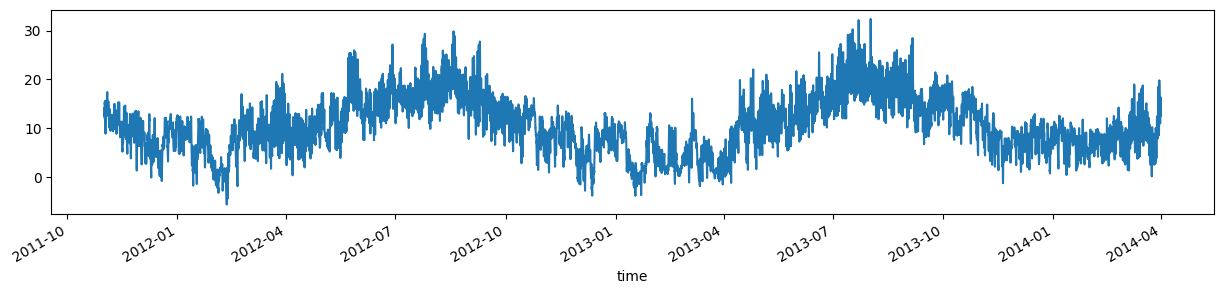

In [7]:
#only take temperature data from weather data
temperaturedata = weather_hourly_darksky['temperature']
#plot 
temperaturedata.plot(figsize=(15,3))

In [8]:
#import preprocssing package
from sklearn import preprocessing
#load uk_bank_holidays.csv
dfholiday = pd.read_csv(os.path.join(datapath,'uk_bank_holidays.csv'))
#set the time
dfholiday['Bank holidays'] = pd.to_datetime(dfholiday['Bank holidays'])
#change columns name
dfholiday = dfholiday.rename(columns={'Bank holidays':'date','Type':'Holiday'})

In [9]:
#using LabelEncoder() to change to digit 
calendarencoder = preprocessing.LabelEncoder()
dfholiday['Holiday'] = calendarencoder.fit_transform(dfholiday['Holiday'])

In [14]:
#Use previouse processed average data
meterdataset = houseAVG.copy()
#Add new time columns date, weekday, hour
meterdataset['timestamp'] = meterdataset.index
meterdataset['date'] = pd.to_datetime(meterdataset.index.date)
meterdataset['weekday'] = meterdataset.index.weekday
meterdataset['hour'] = meterdataset.index.hour + meterdataset.index.minute/60
#add temperature information
meterdataset = meterdataset.merge(temperaturedata, left_index=True, right_index=True)
#add holiday information
meterdataset = meterdataset.merge(dfholiday, on='date', how='left')
#drop date column
#meterdataset = meterdataset.drop('date',axis=1)
#add Holiday column name
meterdataset['Holiday'] = meterdataset['Holiday'].fillna(-1)
#set index
meterdataset.set_index('timestamp',inplace=True)
#delete NA
meterdataset = meterdataset.dropna()

In [11]:
#setup a printing function for print one month result for easy understanding
def testdata_plot(df):
    plt.figure(figsize=(15,2))
    plt.plot(df.loc['2013-12'].index, df.loc['2013-12','kWh'], '-g', alpha=0.6, label='kWh')
    plt.plot(df.loc['2013-12'].index, df.loc['2013-12','kWh_pred'], '--r', alpha=0.8, label='kWh_pred')
    plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
    plt.show() 
    print("*******************************************************************************************************************")
    status = True
    return None

Model: Linear regression Ridge
R²: 0.5888
Mean Absolute Error: 0.0414


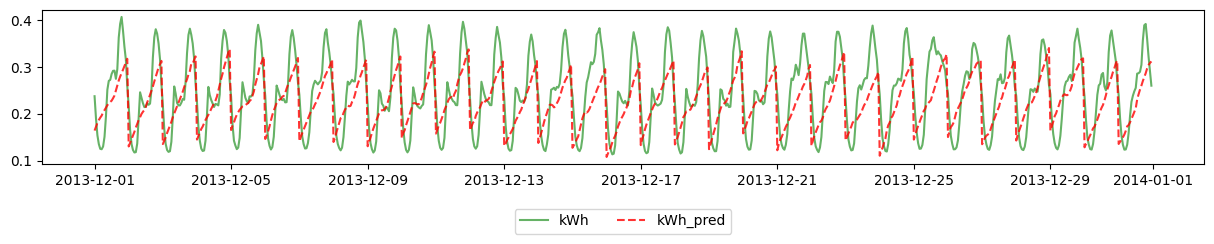

*******************************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 7294, number of used features: 4
[LightGBM] [Info] Start training from score 0.205087
Model: LGBM
R²: 0.8698
Mean Absolute Error: 0.0212


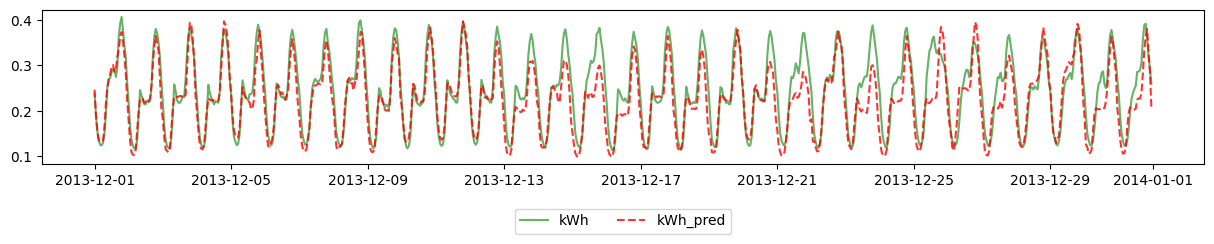

*******************************************************************************************************************


In [12]:
#make feature variables list
featurelist = ['weekday','hour', 'temperature', 'Holiday']
#set training data from Jan 2013 to Oct 2013
traindata = meterdataset.loc['2013-01':'2013-10'].copy()
traindata1 = meterdataset.loc['2013-01':'2013-6'].copy()
traindata2 = meterdataset.loc['2013-7':'2013-10'].copy()
#set test data from Nov 2013 to Feb 2014
testdata = meterdataset.loc['2013-11':].copy()
#Ridge Model Training and testing
Ridge_model = Ridge()
Ridge_model.fit(traindata[featurelist], traindata['kWh'])
testdata['kWh_pred'] = Ridge_model.predict(testdata[featurelist])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])
#plot month of December
print("Model: Linear regression Ridge")
print("R\u00B2: "+str(round(RSQUARED,4)))
print("Mean Absolute Error: "+str(round(MAE,4)))
testdata_plot(testdata)
#LGBM traing and testing
LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[featurelist], traindata['kWh'])
testdata['kWh_pred'] = LGB_model.predict(testdata[featurelist])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])
#plot month of December
print("Model: LGBM")
print("R\u00B2: "+str(round(RSQUARED,4)))
print("Mean Absolute Error: "+str(round(MAE,4)))
testdata_plot(testdata)

In [17]:
meterdataset['year'] = pd.DatetimeIndex(meterdataset['date']).year
meterdataset['month'] = pd.DatetimeIndex(meterdataset['date']).month

In [18]:
meterdataset

,kWh,date,weekday,hour,temperature,Holiday,year,month
timestamp,,,,,,,,
2011-11-23 09:00:00,0.284500,2011-11-23,2,9.0,4.84,-1.0,2011,11
2011-11-23 10:00:00,0.153333,2011-11-23,2,10.0,5.74,-1.0,2011,11
2011-11-23 11:00:00,0.110286,2011-11-23,2,11.0,7.67,-1.0,2011,11
2011-11-23 12:00:00,0.394222,2011-11-23,2,12.0,8.84,-1.0,2011,11
2011-11-23 13:00:00,0.258333,2011-11-23,2,13.0,9.87,-1.0,2011,11
...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,0.347004,2014-02-27,3,20.0,5.94,-1.0,2014,2
2014-02-27 21:00:00,0.334706,2014-02-27,3,21.0,5.03,-1.0,2014,2
2014-02-27 22:00:00,0.299760,2014-02-27,3,22.0,4.10,-1.0,2014,2


In [25]:
!python .\format_data.py